In [1]:
from pyspark import SparkConf, SparkContext
import csv
import statistics
import seaborn as sns
import random
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def cal_RMSE(output_file_path, test_file_path):
    conf = SparkConf().set('spark.driver.host', '127.0.0.1')
    sc = SparkContext(master='local', appName='myAppName', conf=conf)
    raws = []
    with open(output_file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                raws.append([row[0] + ',' + row[1], float(row[2])])
    predict_val_pair = sc.parallelize(raws)

    raws = []
    with open(test_file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                raws.append([row[0] + ',' + row[1], float(row[2])])
    ground_val_pair = sc.parallelize(raws)

    val_RMSE = (ground_val_pair.join(predict_val_pair).map(lambda x: (x[1][0] - x[1][1]) ** 2).mean()) ** 0.5
    sc.stop()
    return val_RMSE

In [3]:
print(cal_RMSE("./task2_case2_local_user_based.txt", "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_val.csv"))

1.169810245949183


In [5]:
def emit_rating_pairs_user_base(lines, uid2idx_bc, bid2idx_bc, key='user', method=1):
    if key == 'user':
        if method == 1:
            for line in lines:
                yield (uid2idx_bc.value[line[0]],
                       [(bid2idx_bc.value[line[1]], float(line[2]))])
        elif method == 2:
            for line in lines:
                yield (uid2idx_bc.value[line[0]], [bid2idx_bc.value[line[1]]])
    elif key == 'business':
        for line in lines:
            yield (bid2idx_bc.value[line[1]], [uid2idx_bc.value[line[0]]])


def rating_dict(rating_lines):
    for line in rating_lines:
        yield (line[0], dict(line[1]))


def emit_pairs_user_base(lines, uid2idx_bc, bid2idx_bc):
    for line in lines:
        pair = []
        if line[0] in uid2idx_bc.value.keys():
            pair.append(uid2idx_bc.value[line[0]])
        else:
            pair.append(line[0])
        if line[1] in bid2idx_bc.value.keys():
            pair.append(bid2idx_bc.value[line[1]])
        else:
            pair.append(line[1])
        yield pair


def emit_id_pairs_user_base(lines, uidx2id_bc, bidx2id_bc):
    for line in lines:
        if isinstance(line[0], int):
            uid = uidx2id_bc.value[line[0]]
        else:
            uid = line[0]
        if isinstance(line[1], int):
            bid = bidx2id_bc.value[line[1]]
        else:
            bid = line[1]
        string = '{},{},{:.10f}'.format(uid, bid, line[2])
        yield string


def cal_weight(user1_ratings, user2_ratings):
    # normalize first
    n = len(user1_ratings)
    mean1 = sum(user1_ratings) / float(n)
    mean2 = sum(user2_ratings) / float(n)
    user1_ratings = [i - mean1 for i in user1_ratings]
    user2_ratings = [i - mean2 for i in user2_ratings]
    numerator = sum([r1 * r2 for r1, r2 in zip(user1_ratings, user2_ratings)])
    denominator = (sum([r1 ** 2 for r1 in user1_ratings]) * sum([r2 ** 2 for r2 in user2_ratings])) ** 0.5
    if denominator > 0:
        pearson_sim = numerator / denominator
    else:
        pearson_sim = 0
    return pearson_sim, mean2


def emit_id_rating_pairs(lines, uidx2id_bc, bidx2id_bc):
    for line in lines:
        yield [uidx2id_bc.value[line[0]], bidx2id_bc.value[line[1]], line[2]]


def emit_avg_pairs(lines, avg_bc):
    for line in lines:
        yield [line[0], line[1], avg_bc.value]


def user_based_predict(pairs, user_ratings_bc, user_bidxs_bc, business_uidx_bc, global_avg_bc):
    for pair in pairs:
        user1 = pair[0]
        business = pair[1]

        if isinstance(user1, int) and isinstance(business, int):
            weighted_ratings = []
            weights = []
            corated_users = business_uidx_bc.value[business]
            yield len(corated_users)

In [4]:
train_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_train.csv"
test_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_val.csv"
conf = SparkConf().set('spark.driver.host', '127.0.0.1')
sc = SparkContext(master='local', appName='myAppName', conf=conf)

In [6]:
raw_train = sc.textFile(train_file)
header = raw_train.first()
train_data = raw_train.filter(lambda x: x != header).mapPartitions(lambda x: csv.reader(x))

global_avg = train_data.map(lambda x: float(x[2])).mean()
global_avg_bc = sc.broadcast(global_avg)

user_ids = train_data.map(lambda x: x[0]).distinct().collect()
# user_cnt = len(user_ids)
business_ids = train_data.map(lambda x: x[1]).distinct().collect()
# business_cnt = len(business_ids)

uid2idx = dict()
bid2idx = dict()
uidx2id = dict()
bidx2id = dict()
for idx, uid in enumerate(user_ids, 0):
    uid2idx[uid] = idx
    uidx2id[idx] = uid

for idx, bid in enumerate(business_ids, 0):
    bid2idx[bid] = idx
    bidx2id[idx] = bid

uidx2id_bc = sc.broadcast(uidx2id)
bidx2id_bc = sc.broadcast(bidx2id)
uid2idx_bc = sc.broadcast(uid2idx)
bid2idx_bc = sc.broadcast(bid2idx)

# (uidx, [(bidx1, rating1),
#         (bidx2, rating2),
#          ...])
users_column = train_data.mapPartitions(
    lambda lines: emit_rating_pairs_user_base(lines, uid2idx_bc, bid2idx_bc, key='user')).reduceByKey(
    lambda a, b: a + b)
users_column.persist()

# {uidx: {bidx1: rating1, bidx2: rating2, ...},
#  ...}
user_ratings = users_column.mapPartitions(lambda cols: rating_dict(cols)).collectAsMap()
user_ratings_bc = sc.broadcast(user_ratings)
users_column.unpersist()

user_bidxs = train_data.mapPartitions(
    lambda lines: emit_rating_pairs_user_base(lines, uid2idx_bc, bid2idx_bc, key='user', method=2)).reduceByKey(
    lambda a, b: a + b).collectAsMap()
user_bidxs_bc = sc.broadcast(user_bidxs)

# {bidx:[uidx1, uidx2, ...],
#  ...}
business_uidx = train_data.mapPartitions(
    lambda lines: emit_rating_pairs_user_base(lines, uid2idx_bc, bid2idx_bc, key='business')).reduceByKey(
    lambda a, b: a + b).collectAsMap()
business_uidx_bc = sc.broadcast(business_uidx)

raw_test = sc.textFile(test_file)
test_header = raw_test.first()
# [uid,bid,str(score)]
test_data = raw_test.filter(lambda x: x != test_header).mapPartitions(lambda x: csv.reader(x))
# [uidx,bidx]
test_pairs = test_data.mapPartitions(lambda lines: emit_pairs_user_base(lines, uid2idx_bc, bid2idx_bc))
test_pairs.persist()
# ['uid,bid,pred']
corated_cnt = test_pairs.mapPartitions(
    lambda pairs: user_based_predict(pairs, user_ratings_bc, user_bidxs_bc, business_uidx_bc, global_avg_bc)).collect()
# sc.stop()

In [7]:
corated_cnt = sorted(corated_cnt)

In [30]:
max(corated_cnt),corated_cnt[-500]

(556, 490)

In [8]:
pd.Series(corated_cnt).value_counts()

11     3492
9      3318
7      3222
10     3218
12     3044
       ... 
221      44
154      44
218      43
140      42
142      33
Length: 253, dtype: int64

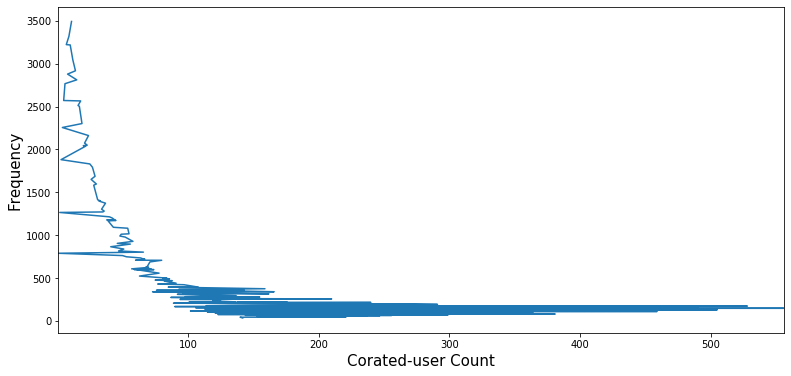

In [16]:
plt.figure(figsize=(13,6))
xxx = pd.Series(corated_cnt).value_counts()
pd.Series(corated_cnt).value_counts().plot()
plt.xlabel("Corated-user Count",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.savefig("./corated_cnt.png",bbox_inches='tight',dpi=300)

In [32]:
x = [[random.randrange(1, 101, 1) for _ in range(30)] for j in range(10000)]
y = [[random.randrange(1, 101, 1) for _ in range(30)] for j in range(10000)]
%timeit [cal_weight(xi,yi) for xi,yi in zip(x,y)] 
%timeit [pearson_sim(xi,yi) for xi,yi in zip(x,y)] 

548 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
105 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
weights = [-0.3,0.45,3.5,0]
sorted_arg = sorted(range(len(weights)), key=weights.__getitem__)
sorted_arg.reverse()
[abs(weights[i]) for i in sorted_arg[:3]]

[3.5, 0.45, 0]

In [15]:
user_rating_cnt = dict()
for k in user_ratings:
    user_rating_cnt[k] = len(user_ratings[k])

(<matplotlib.axes._subplots.AxesSubplot at 0x1a1f99ecc0>, 1062, 18)

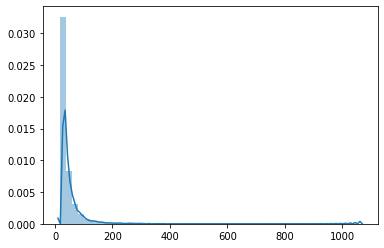

In [19]:
sns.distplot(list(user_rating_cnt.values())), max(list(user_rating_cnt.values())), min(list(user_rating_cnt.values()))

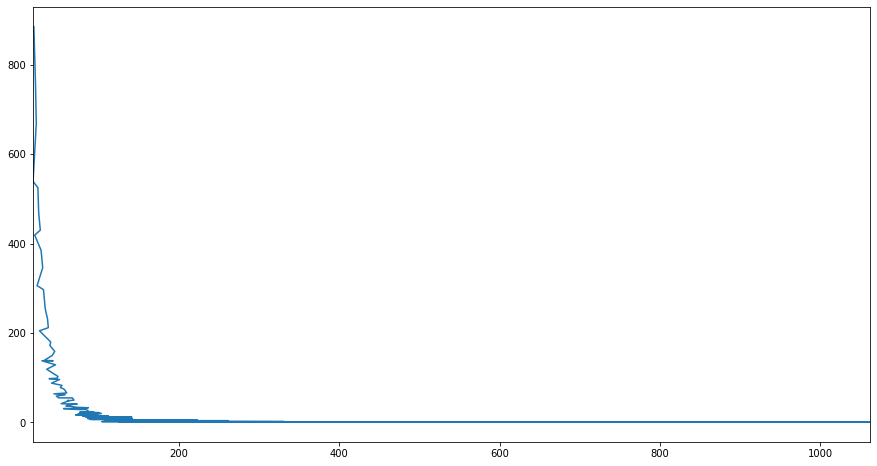

In [23]:
plt.figure(figsize=(15,8))
pd.Series(list(user_rating_cnt.values())).value_counts().plot()


In [4]:
conf = SparkConf().set('spark.driver.host','127.0.0.1')
sc = SparkContext(master='local', appName='myAppName',conf=conf)

In [5]:
train_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_train.csv"
test_file = "/Users/liangsiqi/Documents/Dataset/yelp_rec_data/yelp_val.csv"

raw_train = sc.textFile(train_file)
header = raw_train.first()
train_data = raw_train.filter(lambda x: x != header).mapPartitions(lambda x: csv.reader(x))
print(train_data.take(1))

train_data.persist()

global_avg = train_data.map(lambda x: float(x[2])).mean()
global_avg_bc = sc.broadcast(global_avg)
print("Global avg:%.4f" % global_avg)

user_ids = train_data.map(lambda x: x[0]).distinct().collect()
user_cnt = len(user_ids)
business_ids = train_data.map(lambda x: x[1]).distinct().collect()
business_cnt = len(business_ids)

uid2idx = dict()
bid2idx = dict()
uidx2id = dict()
bidx2id = dict()
for idx, uid in enumerate(user_ids, 0):
    uid2idx[uid] = idx
    uidx2id[idx] = uid

for idx, bid in enumerate(business_ids, 0):
    bid2idx[bid] = idx
    bidx2id[idx] = bid

uidx2id_bc = sc.broadcast(uidx2id)
bidx2id_bc = sc.broadcast(bidx2id)
uid2idx_bc = sc.broadcast(uid2idx)
bid2idx_bc = sc.broadcast(bid2idx)

[['vxR_YV0atFxIxfOnF9uHjQ', 'gTw6PENNGl68ZPUpYWP50A', '5.0']]
Global avg:3.7512


In [6]:
# (uidx, [(bidx1, rating1),
#         (bidx2, rating2),
#          ...])
users_column = train_data.mapPartitions(lambda lines: emit_rating_pairs(lines,uid2idx_bc, bid2idx_bc,key='user')).reduceByKey(lambda a,b: a+b)

# {uidx: {bidx1: rating1, bidx2: rating2, ...},
#  ...}
user_ratings = users_column.mapPartitions(lambda cols: rating_dict(cols)).collectAsMap()
user_ratings_bc = sc.broadcast(user_ratings)


# (bidx, [(uidx1, rating1),
#         (uidx2, rating2),
#          ...])
businesses_rows = train_data.mapPartitions(lambda lines: emit_rating_pairs(lines,uid2idx_bc, bid2idx_bc,key='business')).reduceByKey(lambda a,b: a+b)
# {bidx: {uidx1: rating1, uidx2: rating2, ...},
#  ...}
business_ratings = businesses_rows.mapPartitions(lambda rows: rating_dict(rows)).collectAsMap()
business_ratings_bc = sc.broadcast(business_ratings)

In [7]:
raw_test = sc.textFile(test_file)
test_header = raw_test.first()
# [uid,bid,str(score)]
test_data = raw_test.filter(lambda x: x != test_header).mapPartitions(lambda x: csv.reader(x))
# [uidx,bidx]
test_pairs = test_data.mapPartitions(lambda lines: emit_pairs(lines,uid2idx_bc, bid2idx_bc))

In [11]:
test_pred_idx_pair = test_pairs.mapPartitions(lambda pairs: user_based_predict(pairs, user_ratings_bc, business_ratings_bc,global_avg_bc))
test_pred_id_pair = test_pred_idx_pair.mapPartitions(lambda lines: emit_id_pairs(lines,uidx2id_bc, bidx2id_bc)).collect()

with open("./xxx.csv", 'w') as out_f:
    print("user_id, business_id, prediction", file=out_f)
    for line in test_pred_id_pair:
        print(line, file=out_f)

In [12]:
raws = []
with open("./xxx.csv", 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            raws.append([row[0] + ',' + row[1], float(row[2])])
predict_val_pair = sc.parallelize(raws)

raws = []
with open(test_file, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            raws.append([row[0] + ',' + row[1], float(row[2])])
ground_val_pair = sc.parallelize(raws)

val_RMSE = (ground_val_pair.join(predict_val_pair).map(lambda x: (x[1][0] - x[1][1]) ** 2).mean()) ** 0.5
print("RMSE=%.10f" % val_RMSE)

RMSE=1.1737780684
